# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import tensorflow as tf
%matplotlib inline

In [2]:
from utils import get_dataset

In [4]:
dataset = get_dataset('./data/processed/*.tfrecord')

INFO:tensorflow:Reading unweighted datasets: ['./data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 123


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [5]:
np.random.seed(100)
colors = [[0.0,0.0,1.0],[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0],[0.0,0.0,1.0]]

In [6]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """


    plt.figure(figsize=(30,15))
    i=0
    for sample in batch:
        ax = plt.subplot(2,5,i+1)
        boxes = sample['groundtruth_boxes'].numpy().tolist()
        classes = sample['groundtruth_classes'].numpy().tolist()
        # print(classes)
        img = sample['image'].numpy()
        width = img.shape[1]
        height = img.shape[0]
        ax.imshow(img)
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        for j  in range(len(boxes)):
            p = Rectangle((boxes[j][1]*width,boxes[j][0]*height),(boxes[j][3]-boxes[j][1])*width,(boxes[j][2]-boxes[j][0])*height,linewidth=1,edgecolor=colors[classes[j]],facecolor='none')
            ax.add_patch(p)
        i+=1
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
        


## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

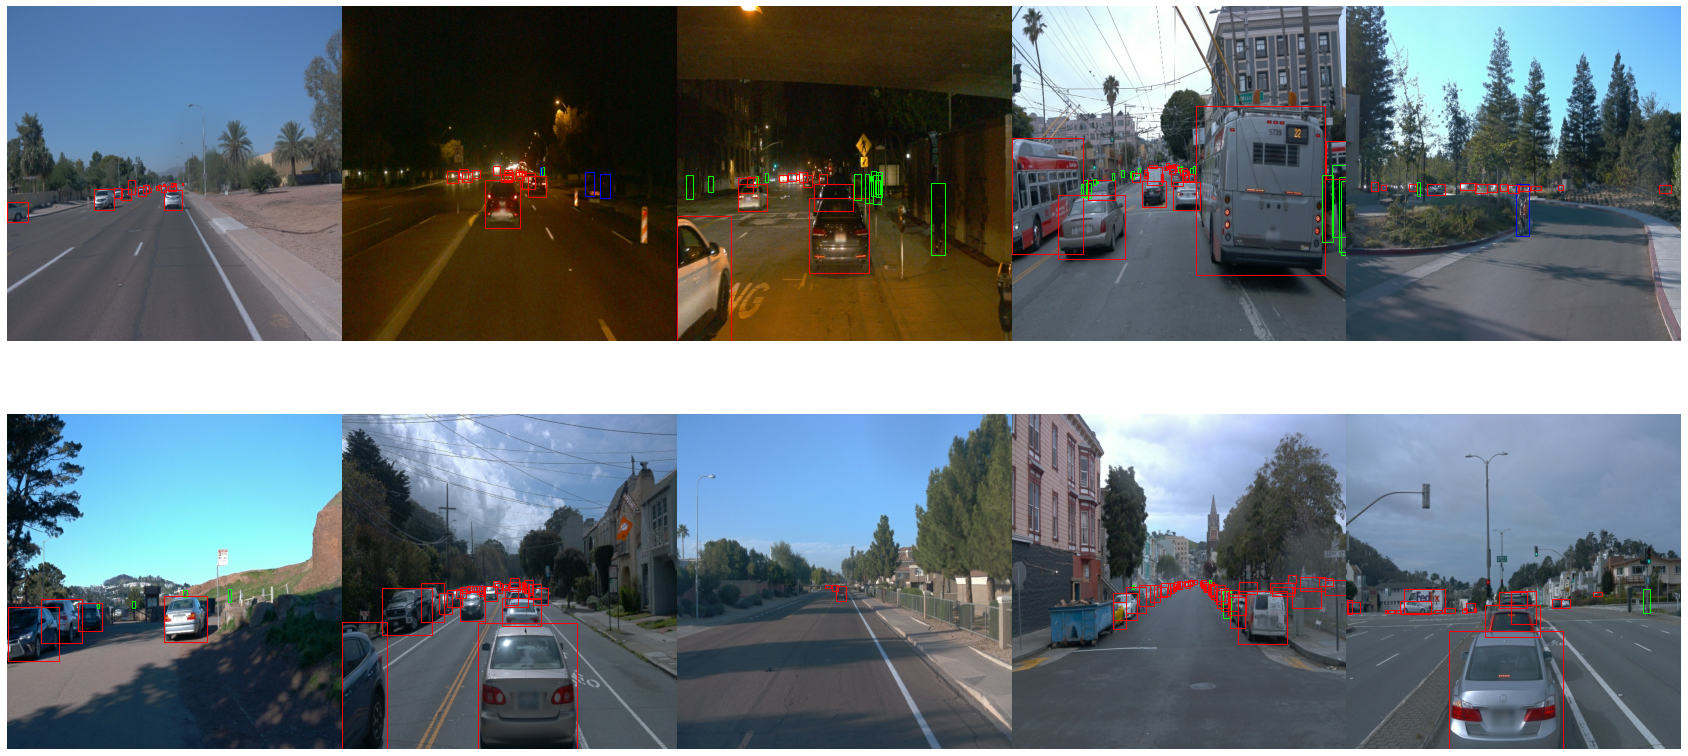

In [12]:
# dataset.shuffle(buffer_size=100)
%matplotlib inline
display_instances(dataset.take(10))

## Additional EDA


In [13]:
import tensorflow_datasets as tfds

In [14]:
df = tfds.as_dataframe(dataset.shuffle(1000).take(5000))
# df.to_pickle('./annotation_eda.pkl')

In [15]:
df.columns

Index(['filename', 'groundtruth_area', 'groundtruth_boxes',
       'groundtruth_classes', 'groundtruth_difficult', 'groundtruth_group_of',
       'groundtruth_image_classes', 'groundtruth_image_confidences',
       'groundtruth_is_crowd', 'groundtruth_not_exhaustive_classes',
       'groundtruth_verified_neg_classes', 'groundtruth_weights', 'image',
       'key', 'original_image_spatial_shape', 'source_id'],
      dtype='object')

In [97]:
labels = []
for i in range(len(df.groundtruth_boxes)):
    for j in range(len(df.groundtruth_boxes[i])):
        x1,y1,x2,y2 = df.groundtruth_boxes[i][j]
        w,h = x2-x1,y2-y1
        type = df.groundtruth_classes[i][j]
        labels.append([x1,y1,x2,y2,w,h,type])
        


In [98]:
df_labels = pd.DataFrame(labels,columns=['x1','y1','x2','y2','w','h','class'])

In [99]:
df_labels['area']=df_labels['w']*df_labels['h']
df_labels['aspect_r'] = df_labels['w']/df_labels['h']
mapping = {1: 'vehicle', 2: 'pedestrian',3:'sign', 4: 'cyclist'}

In [101]:
df_labels.replace({'class':mapping},inplace=True)
df_labels.head()

,x1,y1,x2,y2,w,h,class,area,aspect_r
0,0.518595,0.425007,0.524516,0.431587,0.005921,0.006579,vehicle,0.000039,0.899994
1,0.523529,0.329447,0.542279,0.346223,0.018750,0.016777,vehicle,0.000315,1.117649
2,0.512673,0.441784,0.517608,0.445731,0.004934,0.003947,vehicle,0.000019,1.250004
3,0.519581,0.408231,0.529450,0.417442,0.009869,0.009211,vehicle,0.000091,1.071433
4,0.516621,0.351980,0.522542,0.356585,0.005921,0.004605,vehicle,0.000027,1.285726


<AxesSubplot:ylabel='class'>

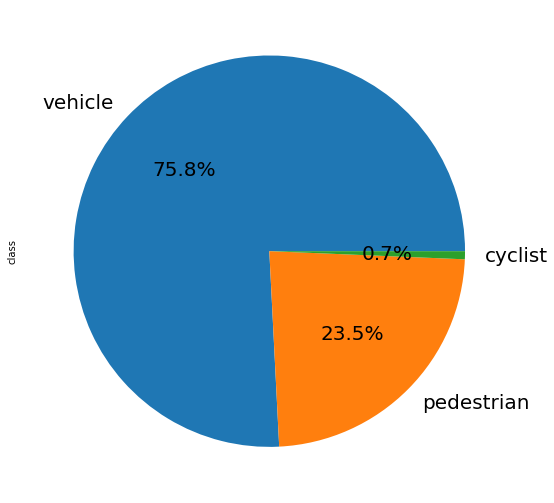

In [125]:
plt.figure(figsize=(12,9))
df_labels['class'].value_counts().plot.pie(labels=['vehicle','pedestrian','cyclist'],fontsize='20',autopct='%1.1f%%')

Text(0, 0.5, 'Count')

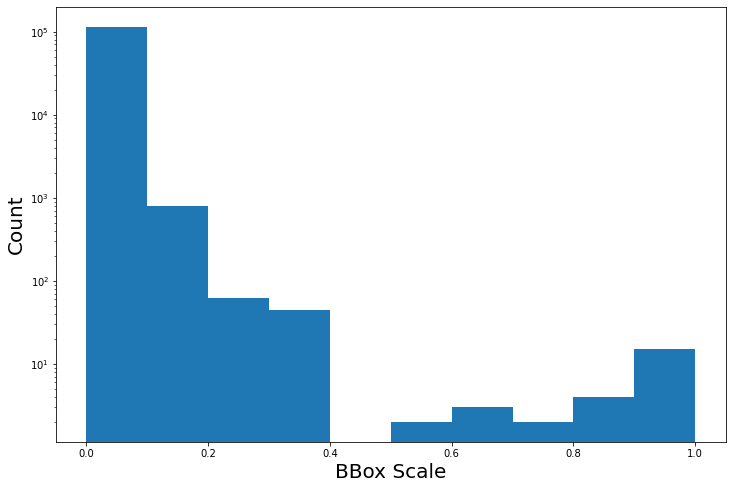

In [103]:
plt.figure(figsize=(12,8))
plt.hist(df_labels.area,range=(0.0,1.0),log=True)
plt.xlabel('BBox Scale',fontsize='20')
plt.ylabel('Count',fontsize='20')

Text(0, 0.5, 'Count')

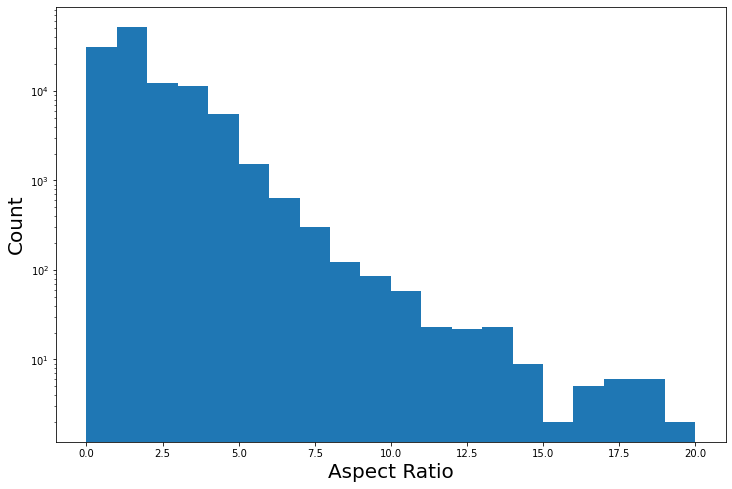

In [120]:
plt.figure(figsize=(12,8))
plt.hist(df_labels.aspect_r,bins=20,range=(0.0,20.0),log=True)
plt.xlabel('Aspect Ratio',fontsize='20')
plt.ylabel('Count',fontsize='20')

In [106]:
df_labels.aspect_r.max()

51.60625

# Class-wise Distributions

Text(0.5, 0, 'BBox Scale')

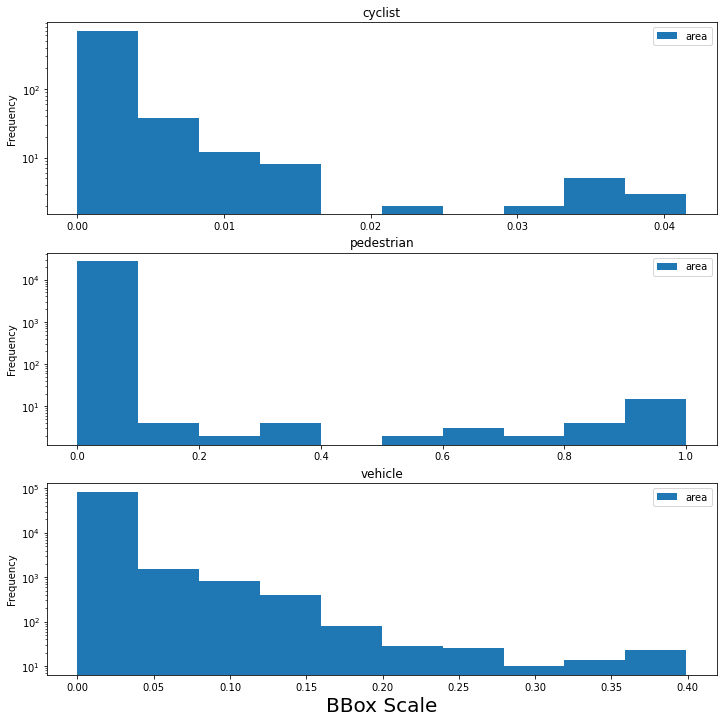

In [115]:
df_labels.plot.hist(column='area',by='class',log=True,figsize=(12,12))
plt.xlabel('BBox Scale',fontsize=20)

Text(0.5, 0, 'BBox Aspect Ratio')

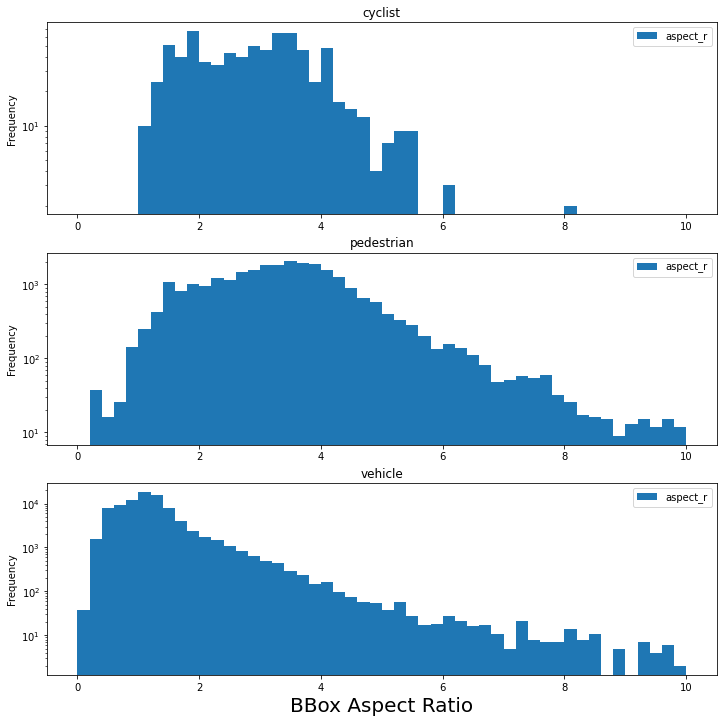

In [123]:
df_labels.plot.hist(column='aspect_r',by='class',log=True,figsize=(12,12),bins=50,range=(0,10))
plt.xlabel('BBox Aspect Ratio',fontsize=20)

# Position dsitributions

In [126]:
df_labels['c_x'] = (df_labels.x1+df_labels.x2)/2
df_labels['c_y'] = (df_labels.y1+df_labels.y2)/2

Text(0.5, 1.0, 'Positional Distribution')

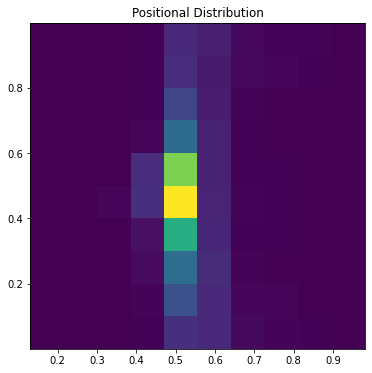

In [146]:
plt.figure(figsize=(6,6))
plt.hist2d(df_labels.c_x,df_labels.c_y,density=True)
plt.title('Positional Distribution')

Text(0.5, 1.0, 'Cyclist')

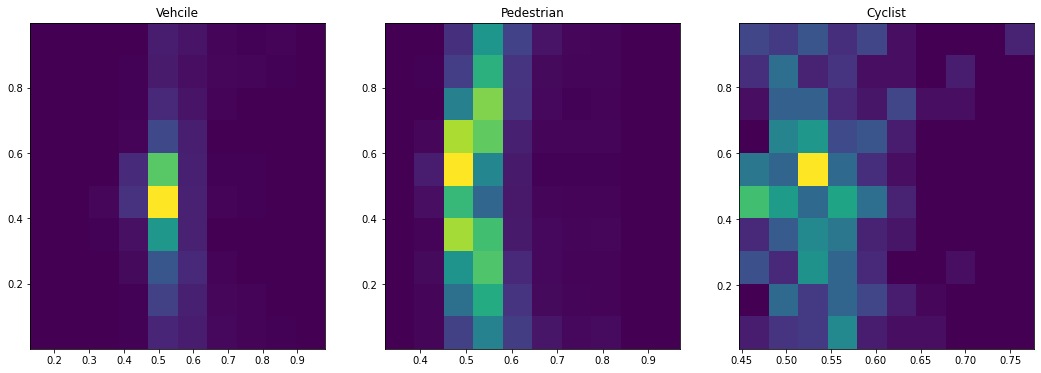

In [145]:
plt.figure(figsize=(18,6))
plt.subplot(131)
df_vehicles = df_labels[df_labels['class']=='vehicle']
plt.hist2d(df_vehicles.c_x,df_vehicles.c_y)
plt.title('Vehcile')
plt.subplot(132)
df_vehicles = df_labels[df_labels['class']=='pedestrian']
plt.hist2d(df_vehicles.c_x,df_vehicles.c_y)
plt.title('Pedestrian')
plt.subplot(133)
df_vehicles = df_labels[df_labels['class']=='cyclist']
plt.hist2d(df_vehicles.c_x,df_vehicles.c_y)
plt.title('Cyclist')

# Custom Anchor Boxes using Clustering

In [1]:
from utils import get_train_input

In [65]:
dataset =  get_train_input("experiments/ssd-augmented/pipeline_new.config")

box_data = []
ar_data = []
def collect_box_data_sample(bboxes):
    for box in bboxes:
        x1,y1,x2,y2 = box
        box_data.append([x2-x1,y2-y1])
        ar_data.append((x2-x1)/(y2-y1))
  

INFO:tensorflow:Reading unweighted datasets: ['/workspaces/urbar-road-osbtacle-detection/data/train/segment-13840133134545942567_1060_000_1080_000_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-14503113925613619599_975_506_995_506_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-1357883579772440606_2365_000_2385_000_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-13679757109245957439_4167_170_4187_170_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-18441113814326864765_725_000_745_000_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-1907783283319966632_3221_000_3241_000_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/data/train/segment-14004546003548947884_2331_861_2351_861_with_camera_labels.tfrecord', '/workspaces/urbar-road-osbtacle-detection/

In [133]:
box_data = []
ar_data= []
for batch in dataset.take(200):
    bboxes = batch[1]['groundtruth_boxes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    batch_size = bboxes.shape[0]
    for idx in range(batch_size):
        collect_box_data_sample(bboxes[idx,:num_bboxes[idx],...])


In [118]:
bd = np.array(box_data)

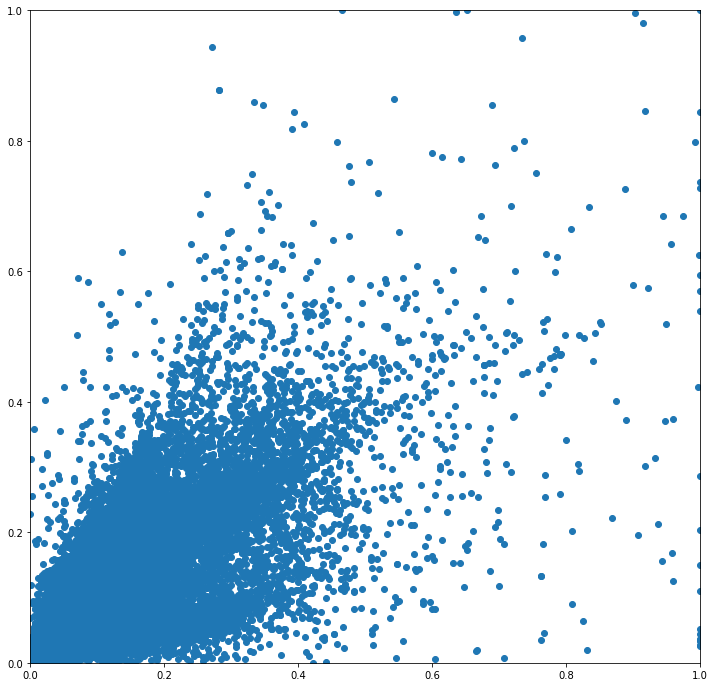

In [134]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.scatter(bd[:,0],bd[:,1])
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.show()


In [51]:

from sklearn.cluster import KMeans

In [120]:
def kmeans_aspect_ratios(bboxes, kmeans_max_iter, num_aspect_ratios):
  
  # Using kmeans to find centroids of the width/height clusters
  kmeans = KMeans(
      init='random', n_clusters=num_aspect_ratios, random_state=0, max_iter=kmeans_max_iter)
  kmeans.fit(X=bboxes)
  ar = kmeans.cluster_centers_

  aspect_ratios = [w/h for w,h in ar]

  return aspect_ratios

def kmeans_1d(ar, kmeans_max_iter, num_aspect_ratios):
  
  # Using kmeans to find centroids of the width/height clusters
  kmeans = KMeans(
      init='random', n_clusters=num_aspect_ratios, random_state=0, max_iter=kmeans_max_iter)
  kmeans.fit(X=ar.reshape(-1,1))
  ar = kmeans.cluster_centers_

  return ar

In [126]:
ar = kmeans_aspect_ratios(bd,500,10)
print("Top aspect ratios are: ",np.sort(ar))

Top aspect ratios are:  [0.80187076 0.9028181  0.93072927 0.9740164  1.279517   1.3589722
 1.605285   1.6064495  3.0262883  3.0495586 ]


In [152]:
ar = kmeans_1d(np.array(ar_data),500,5)
ar=ar.reshape(-1)
print("Top aspect ratios are: ",np.sort(ar))

Top aspect ratios are:  [ 0.9928077  1.9602318  3.787901   8.079439  36.367977 ]


In [68]:
bd.shape

(21801, 2)

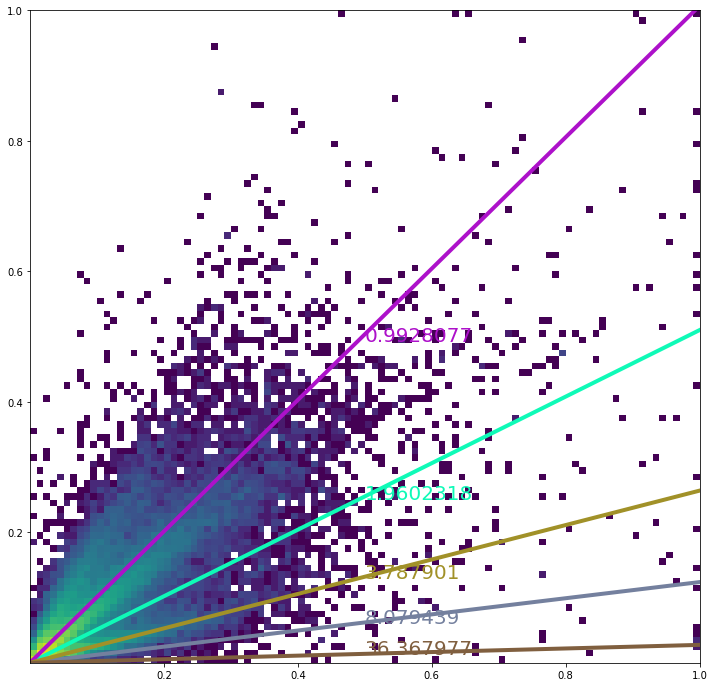

: 

In [154]:
%matplotlib inline
import matplotlib as mpl
plt.figure(figsize=(12,12))
# plt.scatter(bd[:,0],bd[:,1])
plt.hist2d(bd[:,0],bd[:,1],bins=100,norm=mpl.colors.LogNorm())
for a in ar:
    c = np.random.rand(3)
    plt.axline((0, 0), (a, 1), linewidth=4,color=c)
    plt.text(0.5,0.49/a,s=str(a),color=c, fontsize=20)
plt.show()
plt.show()


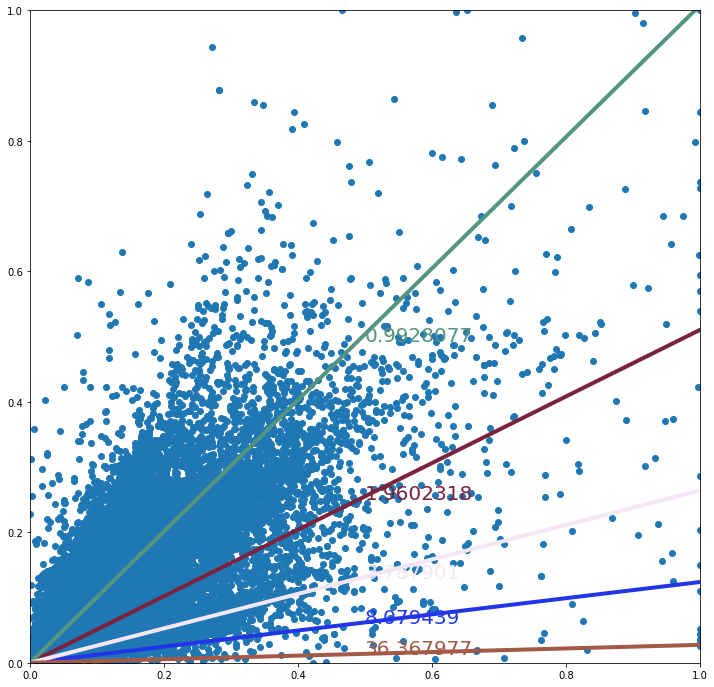

In [153]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.scatter(bd[:,0],bd[:,1])
plt.xlim(0,1.0)
plt.ylim(0,1.0)
ax = plt.gca()
for a in ar:
    c = np.random.rand(3)
    plt.axline((0, 0), (a, 1), linewidth=4,color=c)
    plt.text(0.5,0.49/a,s=str(a),color=c, fontsize=20)
plt.show()
